# Prédiction et simulation des taux d'intérêts immobiliers européens

Le but du projet est de construire des modèles prédictifs des taux d’intérêts immobiliers européens à partir des taux
de rendement des obligations souveraines. Nous y repondront en comprenant les données, et en les manipulant. 

Nous avons mis en place un benchemark (OLS), puis un Random Forest et un Lasso. Les 3 modèles ont été testés sur des données stationaires et non stationaires.
La dernière partie est une méthode de simualtion qui pourrait potentielement être une alternative au modèle de ML.

Les données viennent directement du site de la Banque de France et sont trouvables:

- [Pour les taux moyen mensuel des prêts immobiliers à taux fixe émis dans la
zone Euro dont la maturité est supérieure à 10 ans.](https://sdw.ecb.europa.eu/browseTable.do?org.apache.struts.taglib.html.TOKEN=3ced07bddbe52f0fcc6523e7ecde58a1&df=true&ec=&dc=&oc=&pb=&rc=&DATASET=1&removeItem=&removedItemList=&mergeFilter=&activeTab=MIR&showHide=&MAX_DOWNLOAD_SERIES=500&SERIES_MAX_NUM=50&node=9689358&legendRef=reference&legendPub=published&legendNor=&SERIES_KEY=124.MIR.M.U2.B.A2C.AM.R.A.2250.EUR.N)


- [Pour les taux de rendement moyen mensuel des obligations gouvernementales d’une
maturité de 10 ans dans chaque pays de l’UE](https://sdw.ecb.europa.eu/browseTable.do?org.apache.struts.taglib.html.TOKEN=2b21940a909e3351698b0d6b0a4b876f&df=true&ec=&dc=&oc=&pb=&rc=&DATASET=0&removeItem=&removedItemList=&mergeFilter=&activeTab=IRS&showHide=&MAX_DOWNLOAD_SERIES=500&SERIES_MAX_NUM=50&node=bbn4864&legendRef=reference&legendPub=published)

In [1]:
#import packages
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import scipy.stats as stats
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
import missingno as msno
from sklearn.model_selection import GridSearchCV
import plotly.graph_objs as go
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

C:\Users\nicol\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#pip install missingno

In [3]:
# pip install --upgrade nbformat

## Importation de données

Ici on importe les donners des taux de rendement moyens mensuels des obligations gouvernementales d’une
maturité de 10 ans dans chaque pays de l’UE.

In [4]:
yields = pd.read_csv("eu_yields_.csv", skiprows = [0,1,3,4], index_col = 'Unnamed: 0')[::-1]

In [5]:
yields.columns

Index(['Austria, Euro', 'Belgium, Euro', 'Bulgaria, Bulgarian lev',
       'Cyprus, Euro', 'Czech Republic, Czech koruna', 'Germany, Euro',
       'Denmark, Danish krone', 'Estonia, Euro', 'Spain, Euro',
       'Finland, Euro', 'France, Euro', 'Greece, Euro',
       'Hungary, Hungarian forint', 'Ireland, Euro', 'Italy, Euro',
       'Lithuania, Euro', 'Luxembourg, Euro', 'Latvia, Euro', 'Malta, Euro',
       'Netherlands, Euro', 'Poland, Polish zloty', 'Portugal, Euro',
       'Romania, Romanian leu', 'Sweden, Swedish krona', 'Slovenia, Euro',
       'Slovakia, Euro'],
      dtype='object')

In [6]:
yields.index = list(map(lambda x: datetime.strptime(x, '%Y%b'), yields.index)) # set dates as indexes 
yields.columns = map(lambda x: x.split(',')[0], yields.columns) # rename the columns to only the country without currencies
yields.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
1993-01-01     7.22     7.57       NaN     NaN             NaN     7.15   
1993-02-01     7.13     7.65       NaN     NaN             NaN     6.94   
1993-03-01     6.86     7.37       NaN     NaN             NaN     6.66   
1993-04-01     6.93     7.44       NaN     NaN             NaN     6.68   
1993-05-01     7.06     7.43       NaN     NaN             NaN     6.83   

            Denmark  Estonia  Spain  Finland  ...  Luxembourg Latvia  Malta  \
1993-01-01     8.65      NaN  12.15    10.92  ...         NaN    NaN    NaN   
1993-02-01     8.63      NaN  11.43    10.27  ...         NaN    NaN    NaN   
1993-03-01     8.18      NaN  11.36     9.87  ...         NaN    NaN    NaN   
1993-04-01     7.79      NaN  11.49     9.77  ...         NaN    NaN    NaN   
1993-05-01     7.56      NaN  11.22     9.46  ...         NaN    NaN    NaN   

            Netherlands  Poland  Portugal  Romania  Sweden  Slovenia  Slovakia  
1993-01-01         7.13     NaN       NaN      NaN   10.17       NaN       NaN  
1993-02-01         6.87     NaN       NaN      NaN    9.83       NaN       NaN  
1993-03-01         6.56     NaN       NaN      NaN    9.40       NaN       NaN  
1993-04-01         6.60     NaN       NaN      NaN    9.44       NaN       NaN  
1993-05-01         6.67     NaN       NaN      NaN    9.12       NaN       NaN  

[5 rows x 26 columns]

In [7]:
#Greece: une valeur de '-' est présente dans les données, on le remplace donc avec un 'na'
yields['Greece'] = yields['Greece'].replace (['-'],np.nan)
yields['Greece'] = yields['Greece'].astype(float)

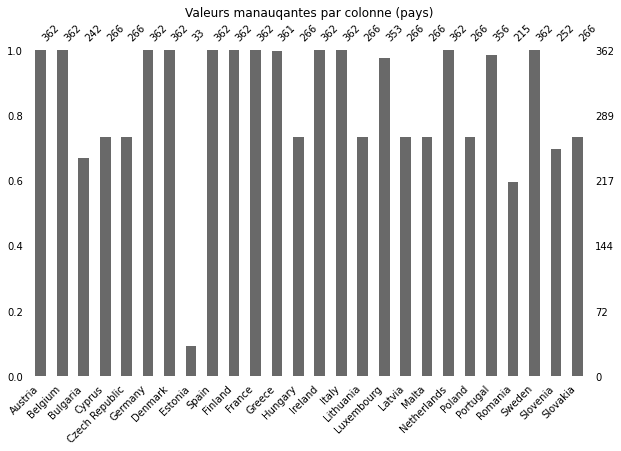

In [8]:
msno.bar(yields, figsize=(10,6), fontsize=10) # plot barchart of missing values
plt.title('Valeurs manauqantes par colonne (pays)');

In [9]:
yields.index.min()

Timestamp('1993-01-01 00:00:00')

In [10]:
yields.index.max()

Timestamp('2023-02-01 00:00:00')

Ici on importe les données des taux moyens mensuels des prêts immobiliers à taux fixe émis dans la
zone Euro dont la maturité est supérieure à 10 ans.

In [11]:
morgage_rate = pd.read_csv("eu_mortgage_rates_.csv", skiprows = [0,1,2,3,4], names = ['dates', 'rates'], index_col = 'dates')[::-1]

In [12]:
morgage_rate.index = list(map(lambda x: datetime.strptime(x, '%Y%b'), morgage_rate.index)) # set date as index
morgage_rate

rates
2003-01-01   4.81
2003-02-01   4.67
2003-03-01   4.54
2003-04-01   4.47
2003-05-01   4.39
...           ...
2022-09-01   2.45
2022-10-01   2.67
2022-11-01   2.89
2022-12-01   2.94
2023-01-01   3.10

[241 rows x 1 columns]

In [13]:
morgage_rate.index.min()

Timestamp('2003-01-01 00:00:00')

In [14]:
morgage_rate.index.max()

Timestamp('2023-01-01 00:00:00')

In [15]:
morgage_rate.iloc[-30:,:]

rates
2020-08-01   1.40
2020-09-01   1.38
2020-10-01   1.36
2020-11-01   1.35
2020-12-01   1.32
2021-01-01   1.33
2021-02-01   1.31
2021-03-01   1.31
2021-04-01   1.31
2021-05-01   1.32
2021-06-01   1.32
2021-07-01   1.32
2021-08-01   1.32
2021-09-01   1.30
2021-10-01   1.31
2021-11-01   1.32
2021-12-01   1.31
2022-01-01   1.33
2022-02-01   1.38
2022-03-01   1.47
2022-04-01   1.61
2022-05-01   1.78
2022-06-01   1.97
2022-07-01   2.15
2022-08-01   2.26
2022-09-01   2.45
2022-10-01   2.67
2022-11-01   2.89
2022-12-01   2.94
2023-01-01   3.10

## Analyse exploratoire de données

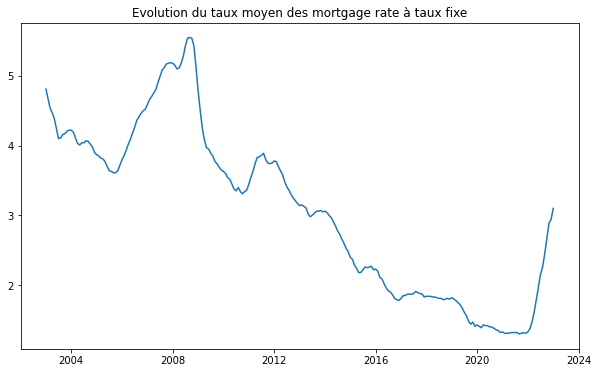

In [16]:
plt.figure(figsize=(10,6))
plt.plot(morgage_rate)
plt.title('Evolution du taux moyen des mortgage rate à taux fixe');

Sur le graphique ci-dessus on peut observer que la série n'est pas stationnaire. On observe également un trend décroissant au fil du temps, à l'excéption de l'année 2022-2023 ou ce trend devient croissant.

In [17]:
# merge the mortgage rates dataset with the yields dataset by date
df = pd.merge(morgage_rate, yields,left_index=True, right_index=True)
df

rates  Austria  Belgium  Bulgaria  Cyprus  Czech Republic  \
2003-01-01   4.81     4.22     4.28      7.20    5.29            4.10   
2003-02-01   4.67     4.01     4.11      6.93    4.83            3.81   
2003-03-01   4.54     4.03     4.15      6.93    4.83            3.75   
2003-04-01   4.47     4.16     4.29      6.79    4.80            3.92   
2003-05-01   4.39     3.85     3.95      6.78    4.63            3.73   
...           ...      ...      ...       ...     ...             ...   
2022-09-01   2.45     2.46     2.45      1.85    3.70            4.72   
2022-10-01   2.67     2.92     2.84      1.85    4.20            5.52   
2022-11-01   2.89     2.70     2.65      1.85    4.19            5.11   
2022-12-01   2.94     2.74     2.70      1.85    4.20            4.71   
2023-01-01   3.10     2.81     2.79      1.85    4.19            4.47   

            Germany  Denmark  Estonia  Spain  ...  Luxembourg  Latvia  Malta  \
2003-01-01     4.18     4.43      NaN   4.24  ...        3.62    4.62   5.54   
2003-02-01     3.95     4.21      NaN   4.01  ...        3.55    4.77   5.51   
2003-03-01     4.00     4.26      NaN   4.04  ...        3.55    4.99   5.40   
2003-04-01     4.15     4.41      NaN   4.19  ...        3.55    4.99   5.25   
2003-05-01     3.82     4.09      NaN   3.88  ...        3.55    4.95   5.14   
...             ...      ...      ...    ...  ...         ...     ...    ...   
2022-09-01     1.80     2.20     2.93   2.92  ...        2.55    2.96   3.30   
2022-10-01     2.19     2.60     4.07   3.29  ...        2.99    3.81   3.80   
2022-11-01     2.07     2.38     3.75   3.06  ...        2.70    3.74   3.44   
2022-12-01     2.08     2.29     3.46   3.09  ...        2.68    3.50   3.59   
2023-01-01     2.19     2.43     3.79   3.20  ...        2.70    3.70   3.55   

            Netherlands  Poland  Portugal  Romania  Sweden  Slovenia  Slovakia  
2003-01-01         4.19    5.66      4.27      NaN    4.70      6.65      4.98  
2003-02-01         3.97    5.66      4.04      NaN    4.47      6.65      4.92  
2003-03-01         4.01    5.52      4.08      NaN    4.57      6.65      5.01  
2003-04-01         4.23    5.41      4.18      NaN    4.72      6.65      4.90  
2003-05-01         3.91    5.12      3.91      NaN    4.37      6.65      4.72  
...                 ...     ...       ...      ...     ...       ...       ...  
2022-09-01         2.14    6.28      2.89     8.07    2.08      1.70      2.87  
2022-10-01         2.52    7.82      3.26     9.13    2.27      2.51      3.55  
2022-11-01         2.35    7.24      3.02     7.65    2.05      3.56      3.37  
2022-12-01         2.43    6.61      3.10     7.17    1.97      3.52      3.20  
2023-01-01         2.50    6.02      3.13     6.80    2.08      3.25      3.25  

[241 rows x 27 columns]

In [18]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2003-01-01 to 2023-01-01
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rates           241 non-null    float64
 1   Austria         241 non-null    float64
 2   Belgium         241 non-null    float64
 3   Bulgaria        241 non-null    float64
 4   Cyprus          241 non-null    float64
 5   Czech Republic  241 non-null    float64
 6   Germany         241 non-null    float64
 7   Denmark         241 non-null    float64
 8   Estonia         32 non-null     float64
 9   Spain           241 non-null    float64
 10  Finland         241 non-null    float64
 11  France          241 non-null    float64
 12  Greece          240 non-null    float64
 13  Hungary         241 non-null    float64
 14  Ireland         241 non-null    float64
 15  Italy           241 non-null    float64
 16  Lithuania       241 non-null    float64
 17  Luxembourg      

Nous décidons de ne pas garder les taux croates, estoniens, grecs et roumains à cause des valeurs manquantes. Intuitivement, nous pensons que la suppression de ces variables ne devrait en rien impacter les modèles présentés.

In [19]:
df = df.drop(['Estonia', 'Romania','Greece'], axis = 1)

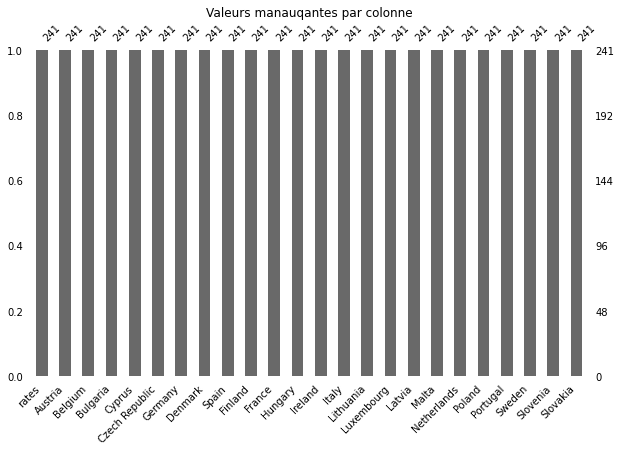

In [20]:
msno.bar(df, figsize=(10,6), fontsize=10)
plt.title('Valeurs manauqantes par colonne'); 

On remarque qu'aucune valeur manquante  n'est présente dans nos données.

In [21]:
#plot the evolution of the yields by country and mortgage rates 
fig = px.line(df, x = df.index, y = df.columns, template = 'plotly_dark', title="L'évolution des taux d'intérêt sur les bonds de 10 ans et les mortgage rate")
fig.show()

Sur ce graphique on montre l'évolution au file de temps des taux d'intérêt de chque pays ainsi que le taux moyen. On remarque quelques pics pour certains pays, comme Portugal en Janvier 2012, Ireland en Juillet 2011. On remarque également une forte croissance pour l'année 2022pour la touts les pays.

C:\Users\nicol\Anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



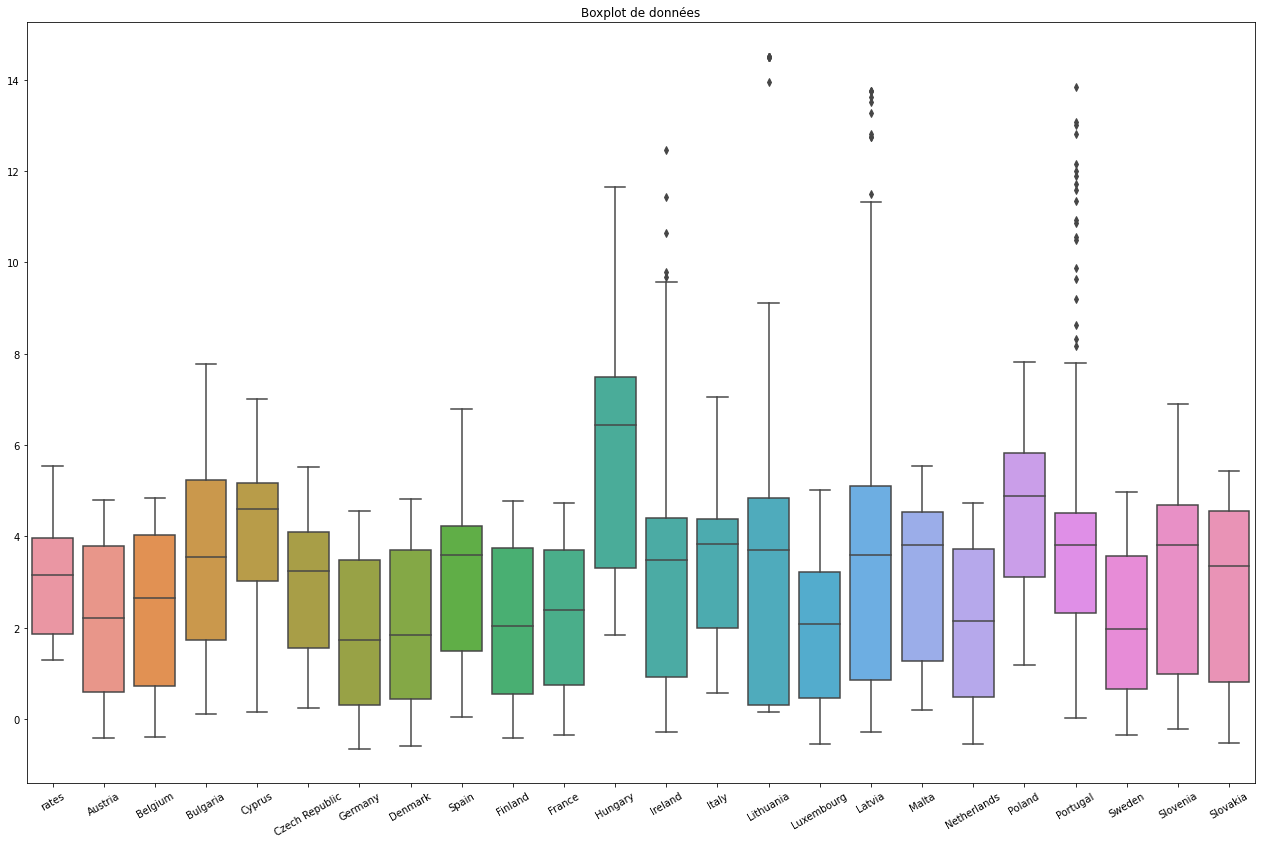

In [22]:
plt.figure(figsize=(22,14))
ax=sns.boxplot(data=df)
plt.title("Boxplot de données")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

À l'aide de ce graphique, on peut observer la variabilité présente dans nos données ainsi que la médiane de ces derniers.  Taux moyen des emprunts immobilier à taux fixe a une variation plus faible en comparaison avec les yields des bonds des pays européen. On observe également que les pays avec la variation la plus élevée des yields sont : La Hongrie, Lituanie, Lettonie et le Portugal. Le pays avec le taux médian le plus haut est la Hongrie et celui avec le taux médian le plus bas est l'Allemagne (celui-là se rapproche du Danemark, Finlande, Luxembourg et la Suède et les Pays-Bas).

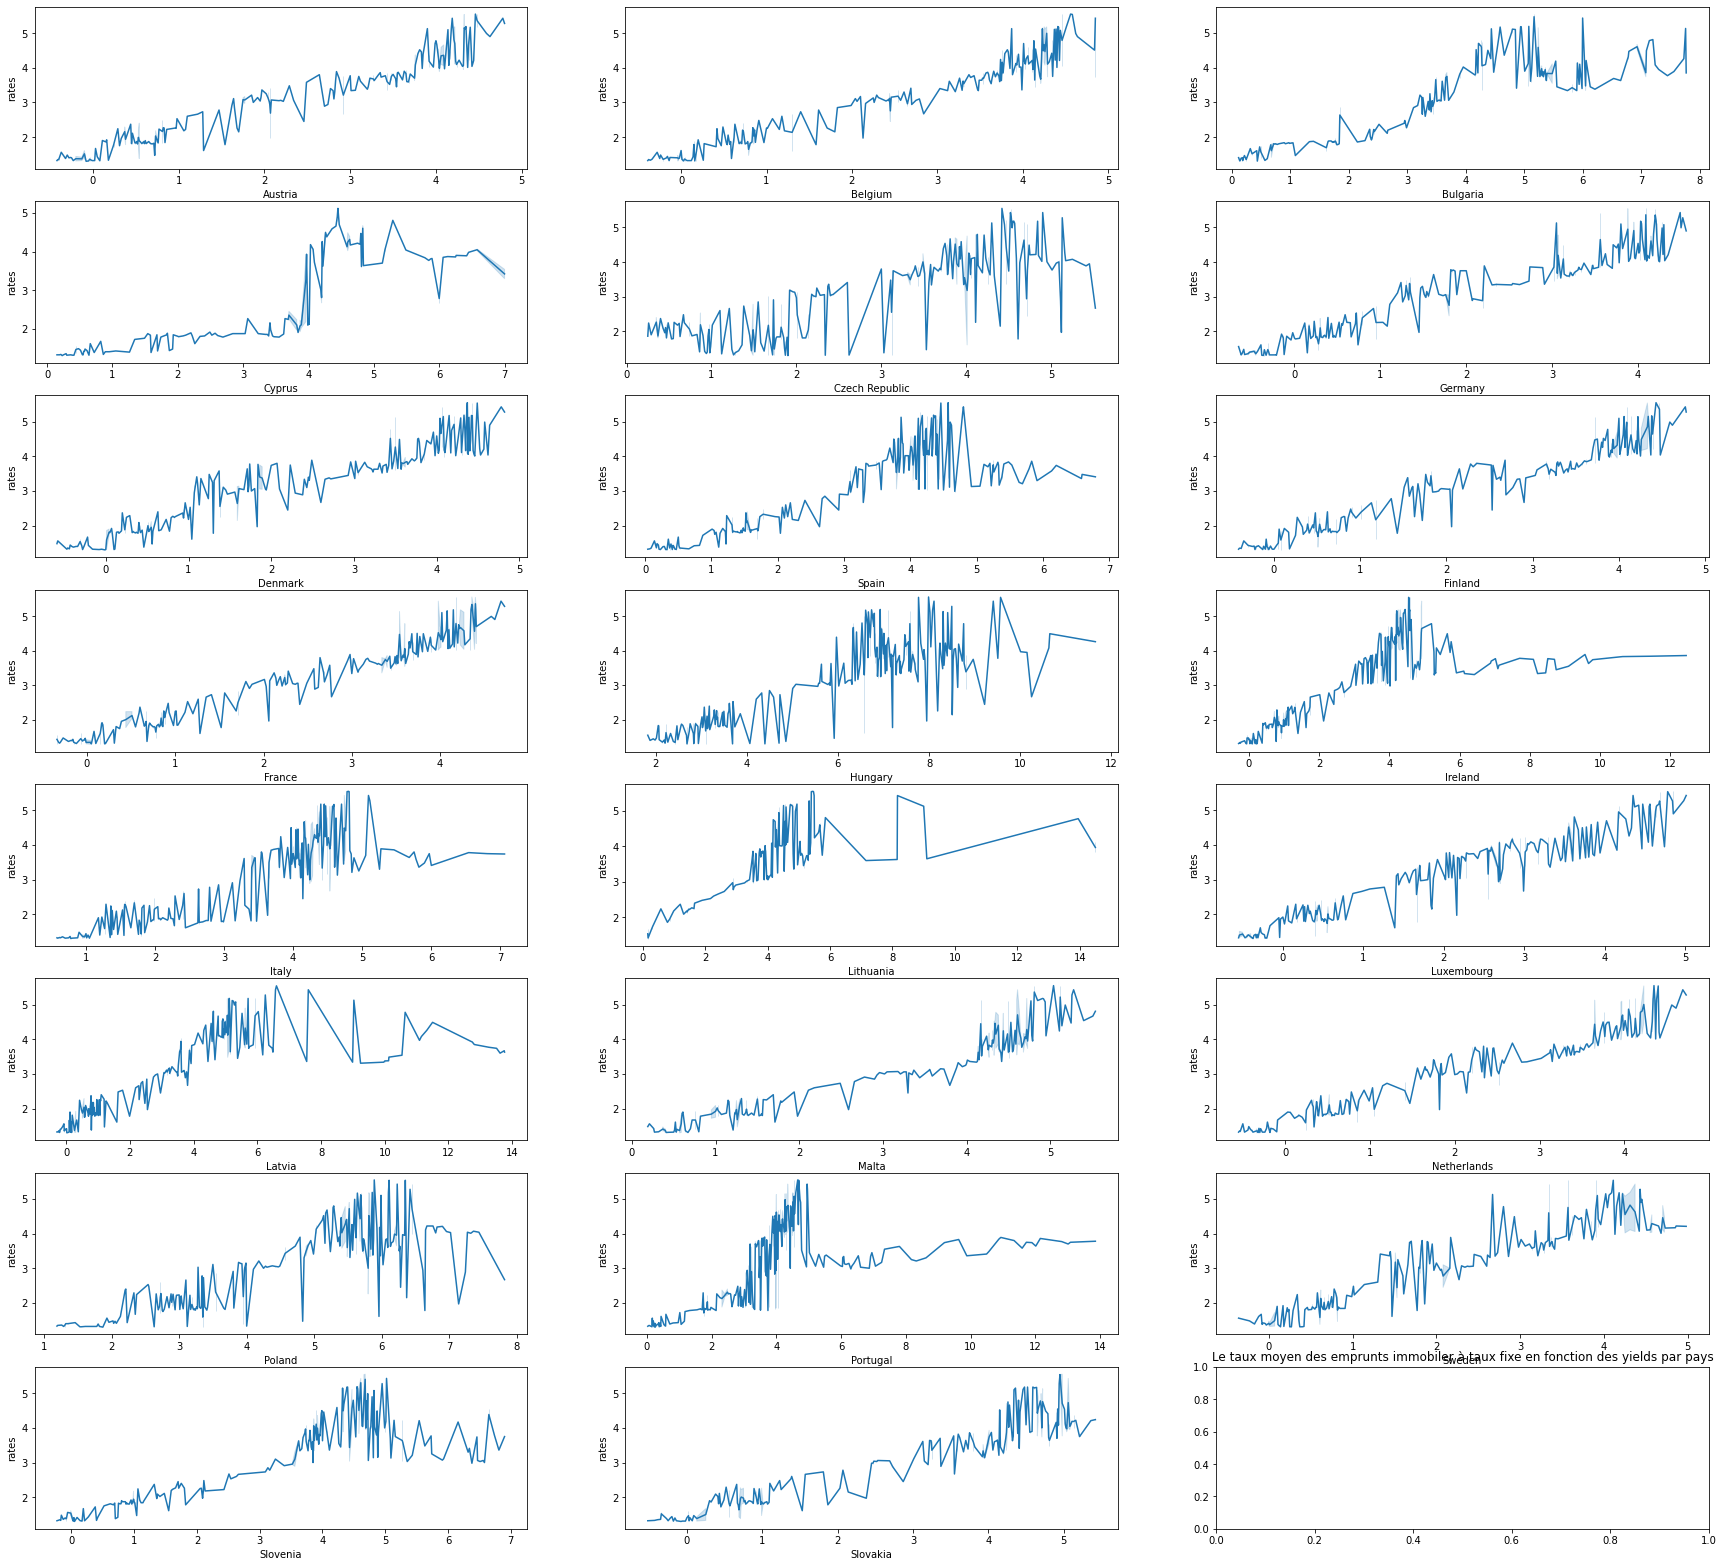

In [23]:
row = 8
col = 3


fig, axes = plt.subplots(row, col, figsize=(30, 28))

for ax,i in zip( axes.ravel(), df.columns[1:]):
    g = sns.lineplot(y = 'rates', x = i, ax= ax, data=df)
plt.title('Le taux moyen des emprunts immobiler à taux fixe en fonction des yields par pays')
plt.show()

On observe de forte relations linéaires entre les rendements des obligations des pays et les taux d'intérêt immobilier pour la Belgique, l'Autriche, le Danemark, la Finlande, l'Allemagne, la France, le Luxembourg, et les Pays Bas. Cependant, certains pays comme la Lituanie, le Portugal ou la Pologne semblent ne pas avoir de relation linéaire.

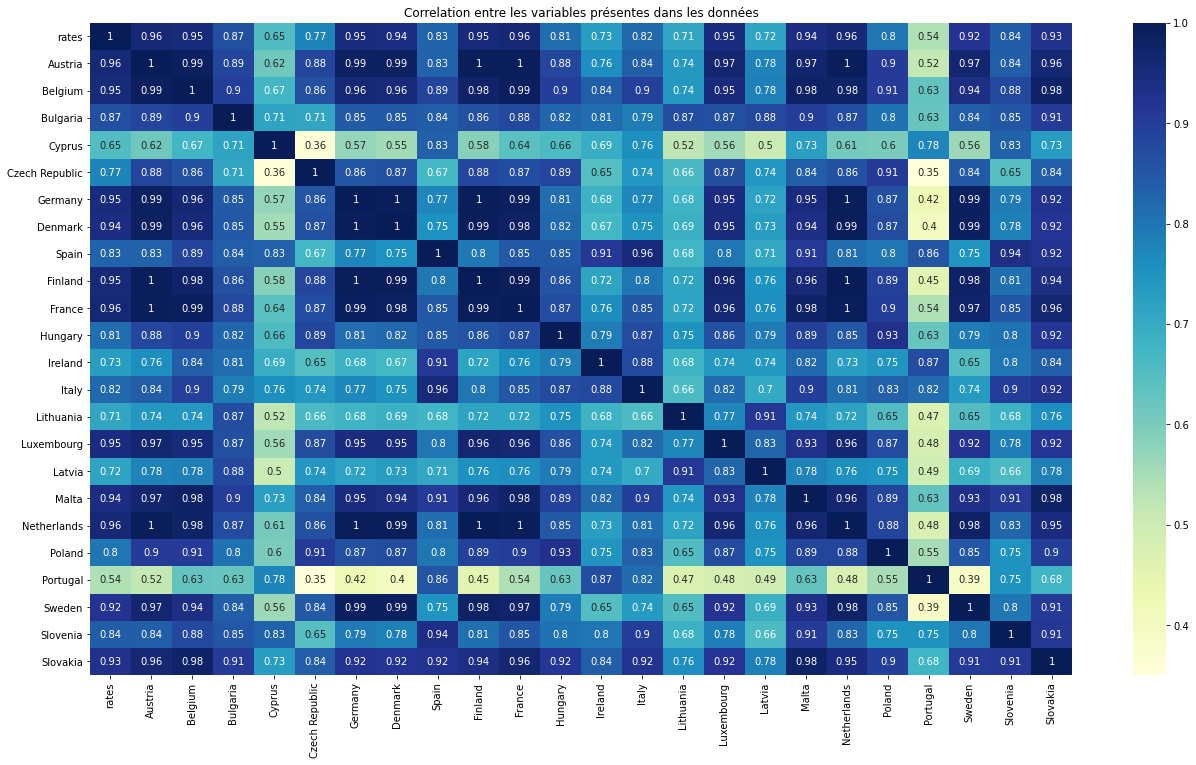

In [24]:
plt.figure(figsize=(22,12))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation entre les variables présentes dans les données");


On remarque des fortes corrélations entre les bonds yields de beaucoup de pays. Par exemple, la corrélation des taux de rendement mensuels des bonds allemand et danois est de 1. D'autres pays ont des rendements de bond plus décorrélés par rapport aux autres pays comme le Portugal ou Chypre.

La variable rates est fortement corrélé avec la plupart pays (hors Portugal et Chypre).

## Modèle Naif: 2 OLS

## Sélection de variables et modélisaiton

De manière très intuitive et sans prêter attention aux graphiques représentants la relation linéaire entre les morgages rates et les bonds 10y des pays, le choix des 2 prédicteurs comme l'Allemagne et l'Espagne se justifie. L'Allemagne, la plus grande force économique de l'Europe, irréprochable sur le plan économique, est la référence européenne. 
L'Espagne, quant à elle, représente les pays un peu plus en difficulté. C'est donc pour ca qu'on décide d'utiliser ces deux pays pour notre premier modèle.

$Y_{t+1} = alpha*Germany_t + beta*Spain_t$

In [25]:
df[['rates', 'Germany', 'Spain']].head()

rates  Germany  Spain
2003-01-01   4.81     4.18   4.24
2003-02-01   4.67     3.95   4.01
2003-03-01   4.54     4.00   4.04
2003-04-01   4.47     4.15   4.19
2003-05-01   4.39     3.82   3.88

In [26]:
dataset = df.iloc[:-1,1:] # take all the columns except "rates"
dataset['rates'] = df.rates.shift(-1) # create the column for the output 
# all the other columns including the column rates are lagged of order 1 in this case
donnee = dataset[['rates', 'Germany', 'Spain']]
donnee.index = df.index[1:] ##############################################################
donnee.head()

rates  Germany  Spain
2003-02-01   4.67     4.18   4.24
2003-03-01   4.54     3.95   4.01
2003-04-01   4.47     4.00   4.04
2003-05-01   4.39     4.15   4.19
2003-06-01   4.24     3.82   3.88

In [27]:
#Pour pouvoir appliquer des modèles, nous nous devons de stationariser les variables.
train = 200 # define the size of the train set
X = donnee.iloc[:train,1:].diff().dropna()
y = donnee.iloc[:train,0].diff().dropna()

In [28]:
X.head()

Germany  Spain
2003-03-01    -0.23  -0.23
2003-04-01     0.05   0.03
2003-05-01     0.15   0.15
2003-06-01    -0.33  -0.31
2003-07-01    -0.20  -0.19

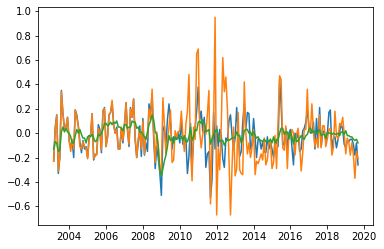

In [29]:
plt.plot(X)
plt.plot(y);

In [30]:
print("Les pvalues des 2 colonnes sont:",[adfuller(X.iloc[:,i])[2] for i in range(0,2)])


Les pvalues des 2 colonnes sont: [0, 0]


Ceci prouve la stationarité des 2 series. 

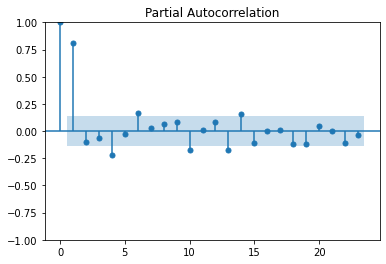

In [31]:
import warnings
warnings.filterwarnings("ignore")
#calculate autocorrelations to see the significant lags 
tsaplots.plot_pacf(y);

Sur ce diagramme, il existe une corrélation significative au niveau du décalage 1 qui diminue après quelques décalages. Cépendant, on remque que décalage 4 et 6 sont aussi significatifs. Pour notre modèle on décide donc de rejouter le décalage 1 comme nouveau 'feature'.

In [32]:
X['y_lagged_1'] = y.shift(1) # create a new feature which is a first lag of the output variable
X = X.dropna()
y = y.iloc[1:]
X.head()

Germany  Spain  y_lagged_1
2003-04-01     0.05   0.03       -0.13
2003-05-01     0.15   0.15       -0.07
2003-06-01    -0.33  -0.31       -0.08
2003-07-01    -0.20  -0.19       -0.15
2003-08-01     0.35   0.34       -0.14

Modèle: $\Delta Y_{t+1} = \Delta Germany_t + \Delta Spain_t$

In [33]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  rates   R-squared (uncentered):                   0.801
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                              261.1
Date:                Sun, 14 May 2023   Prob (F-statistic):                    5.09e-68
Time:                        02:07:56   Log-Likelihood:                          409.47
No. Observations:                 198   AIC:                                     -812.9
Df Residuals:                     195   BIC:                                     -803.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

A partir de ces résultats on peut remarquer que "l'Allemagne" est significative à 5%, tandis que l'Espagne est significative à 10%. On observe également que le décalage 1 est également significatif à 5%. Procédons maintenant à l'analyse des résiduels du modèle.

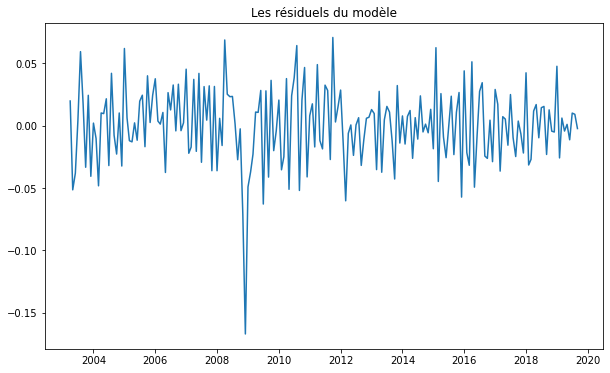

In [34]:
plt.figure(figsize=(10,6))
plt.plot(model.resid)
plt.title("Les résiduels du modèle");

In [35]:
adfuller(model.resid)[:2] # test the stationarity

(-6.614385491819006, 6.260364589541218e-09)

In [36]:
stats.jarque_bera(model.resid) # jarque-bera for normality of the resiudals

SignificanceResult(statistic=112.86732066213999, pvalue=3.0986514285140933e-25)

Après avoir estimé notre modèle, on procède avec des tests de stationnarités et de normalité des résidus. Jarque-Bera test sur les résidus montre que les résidus ne sont pas normalement distribués (pvalue=0.0), ce qui viole l'hypothèse de la régression linéaire. Cependant, on observe des résidus sont stationnaires sans auto-corrélation au vu des résultat des Augmented Dickey-Fuller test et Watson Durbin (2.298).

On observe clairement que le modèle capture très mal la crise de 2008/2009.
La crise liée à la COVID est néanmoins bien capturé malgré les variations de marché. L'interprétation de cette analyse est une réaction différente du marché pendant ces 2 crises. Le marché a réagi moins rapidement et de manière moins accentuée en 2009 qu'en 2020/2021.

In [37]:
# create the test set
X_test = donnee.iloc[train:,1:].diff().dropna()
y_test = donnee.iloc[train:,0].diff().dropna()
X_test['y_lagged_1'] = y_test.shift(1)
X_test = X_test.dropna()
y_test = y_test.iloc[1:]

In [38]:
X_test.head()

Germany  Spain  y_lagged_1
2019-12-01     0.12   0.19        0.03
2020-01-01     0.05   0.04       -0.06
2020-02-01    -0.01  -0.01        0.02
2020-03-01    -0.16  -0.15       -0.02
2020-04-01    -0.07   0.25       -0.02

In [39]:
# make predictions
y_pred_ols = X_test @ np.array(model.params).reshape(len(X_test.columns),1)

Après avoir estimé le modèle sur les données train, on fait des prédictions en utilisant les données test afin d'évaluer la performance du modèle sur des nouvelles données.

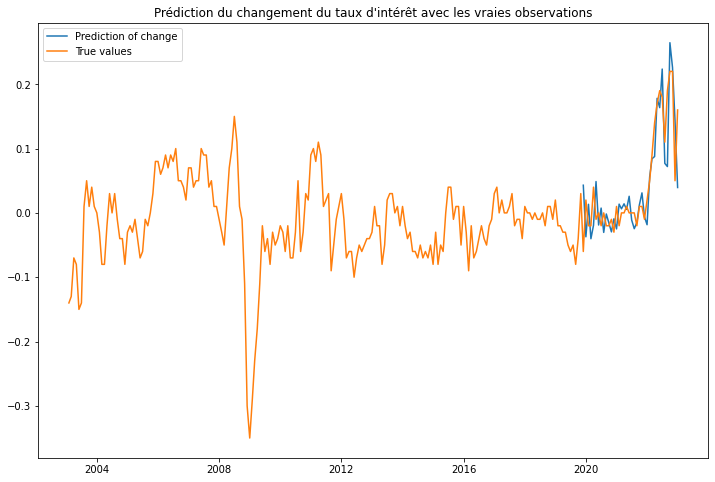

In [40]:
plt.figure(figsize=(12,8))
plt.plot(y_pred_ols)
plt.plot(df.rates.diff())
plt.legend(['Prediction of change','True values']);
plt.title("Prédiction du changement du taux d'intérêt avec les vraies observations");

On remqaue que les valeurs prédites ont des déviations par rapport aux vraies valeurs. Essayons maintenant de quantifier ces déviations grâce à des métriques comme MAE(Mean Absolute Error) et RMSE(Root Mean Squared Error).

MAE (mean absolute errror) et rmse (root mean squared error) sur les changements dans les prédictions:

In [41]:
y_pred_train_ols = X@ np.array(model.params).reshape(len(X.columns),1)

In [42]:
def print_rmse_mse(y, y_pred_ols, y_pred_train_ols, y_test):
    rmse_change = np.sqrt(sum((y - y_pred_train_ols.iloc[:,0])**2) / len(y))
    print('Root Mean Squared Error on train: '+ str(rmse_change))
    rmse_change = np.sqrt(sum((y_test - y_pred_ols.iloc[:,0])**2) / len(y_test))
    print('Root Mean Squared Error on test: '+ str(rmse_change))
    mae_change = sum(abs((y - y_pred_train_ols.iloc[:,0]))) / len(y)
    print('Mean Absolute Error on train: '+ str(mae_change))
    mae_change = sum(abs((y_test - y_pred_ols.iloc[:,0]))) / len(y_test)
    print('Mean Absolute Error on test: '+ str(mae_change))

In [43]:
print_rmse_mse(y, y_pred_ols, y_pred_train_ols, y_test)

Root Mean Squared Error on train: 0.030593818823771313
Root Mean Squared Error on test: 0.045094649638004934
Mean Absolute Error on train: 0.023751345100372866
Mean Absolute Error on test: 0.0330349784825646


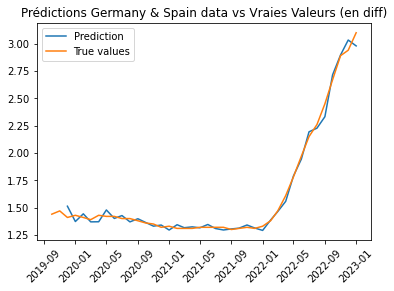

In [44]:
plt.plot(y_pred_ols.iloc[:,0]+ df.rates[201:].shift(1))
plt.plot(df.rates[201:])
plt.legend(['Prediction','True values']);
plt.xticks(rotation = 45);
plt.title("Prédictions Germany & Spain data vs Vraies Valeurs (en diff)");

MAE et RMSE sur les prédictions:

In [45]:
def print_mae_rmse_pred(df,y_pred_ols, y_pred_train_ols, train, y_test):
    mae_prediction = sum(abs((df.rates[:train] - (y_pred_train_ols.iloc[:,0]+ df.rates[:train].shift(1))).dropna())) / len(df.rates[:train-1])
    print('Mean Absolute Error on train: ', mae_prediction)
    mae_prediction = sum(abs((df.rates[train+1:] - (y_pred_ols.iloc[:,0]+ df.rates[train+1:].shift(1))).dropna())) / len(df.rates[train:-1])
    print('Mean Absolute Error on test: ', mae_prediction)
    rmse_prediction = np.sqrt(sum(abs((df.rates[:train] - (y_pred_train_ols.iloc[:,0]+ df.rates[train:].shift(1))).dropna())) / len(df.rates[:train-1]))
    print('Root Mean Squared Error on train: ', rmse_prediction)
    rmse_prediction = np.sqrt(sum(abs((df.rates[train+1:] - (y_pred_ols.iloc[:,0]+ df.rates[train+1:].shift(1))).dropna())) / len(y_test))
    print('Root Mean Squared Error on test: ', rmse_prediction)

In [46]:
print_mae_rmse_pred(df,y_pred_ols, y_pred_train_ols, train, y_test)

Mean Absolute Error on train:  0.02362034322483648
Mean Absolute Error on test:  0.03138322955843635
Root Mean Squared Error on train:  0.0
Root Mean Squared Error on test:  0.181755270852222


**Interprétation**

On observe un R2 de 80% et un mae = 0.033 pour les changements dans les prédictions et de 0.031 pour les prédictions.

Cependant, si on s'attarde sur les praphiques représentants la relation linéaire entre les morgages rates et les bonds 10y des pays, on observe une relation plus linéaire entre la Belgique et les morgage rate. Testons :

Modèle: $\Delta Y_{t+1} = \Delta Belgium_t + \Delta Spain_t$

In [47]:
dataset_2 = df.iloc[:-1,1:]
dataset_2['rates'] = df.rates.shift(-1)
donnee_2 = dataset[['rates', 'Belgium', 'Spain']]
donnee_2.index = df.index[1:]
X_new = donnee_2.iloc[:train,1:].diff().dropna()
y_new = donnee_2.iloc[:train,0].diff().dropna()
X_new['y_lagged_1'] = y_new.shift(1)
X_new =X_new.dropna()

X_test_new = donnee_2.iloc[train:,1:].diff().dropna()
y_test_new = donnee_2.iloc[train:,0].diff().dropna()
X_test_new['y_lagged_1'] = y_test_new.shift(1)
X_test_new = X_test_new.dropna()

In [48]:
model_bel = sm.OLS(y, X_new).fit()
print(model_bel.summary())

                                 OLS Regression Results                                
Dep. Variable:                  rates   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              198.1
Date:                Sun, 14 May 2023   Prob (F-statistic):                    6.08e-59
Time:                        02:07:57   Log-Likelihood:                          388.21
No. Observations:                 198   AIC:                                     -770.4
Df Residuals:                     195   BIC:                                     -760.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [49]:
X_new

Belgium  Spain  y_lagged_1
2003-04-01     0.04   0.03       -0.13
2003-05-01     0.14   0.15       -0.07
2003-06-01    -0.34  -0.31       -0.08
2003-07-01    -0.21  -0.19       -0.15
2003-08-01     0.32   0.34       -0.14
...             ...    ...         ...
2019-05-01    -0.07  -0.08       -0.03
2019-06-01    -0.06  -0.18       -0.03
2019-07-01    -0.26  -0.37       -0.05
2019-08-01    -0.15  -0.15       -0.06
2019-09-01    -0.28  -0.21       -0.05

[198 rows x 3 columns]

In [50]:
# create prediction
y_pred_ols2 = X_test_new @ np.array(model_bel.params).reshape(len(X_test_new.columns),1)
y_pred_train_ols2 = X_new @ np.array(model_bel.params).reshape(len(X_new.columns),1)

In [51]:
print_rmse_mse(y, y_pred_ols2, y_pred_train_ols2, y_test)

Root Mean Squared Error on train: 0.03406055149324859
Root Mean Squared Error on test: 0.042134909536247454
Mean Absolute Error on train: 0.02561067848680604
Mean Absolute Error on test: 0.028844454006633644


MAE et RMSE sur les changements dans les prédictions:

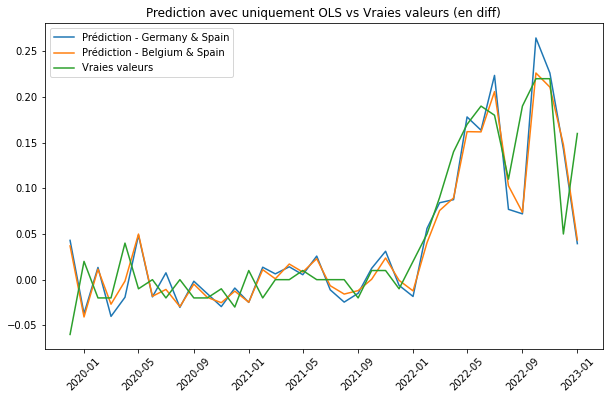

In [52]:
plt.figure(figsize=(10,6))
plt.plot(y_pred_ols)
plt.plot(y_pred_ols2)
plt.plot(df.rates.diff()[train+3:])
plt.legend(['Prédiction - Germany & Spain','Prédiction - Belgium & Spain','Vraies valeurs']);
plt.xticks(rotation = 45);
plt.title("Prediction avec uniquement OLS vs Vraies valeurs (en diff)");

On observe des prédictions de données un peu plus lissées lorsque notre prédicteur Germany est remplacé par le prédicteur Belgium.
L'explication intuitive semble être que la Belgique est une bonne référence européenne quand on parle de moyenne. C'est un pays avec une bonne santé financière, entourée des 2 références européenne (France et Allemagne), bien que ce soit un petit pays (11 millions d'habitants).

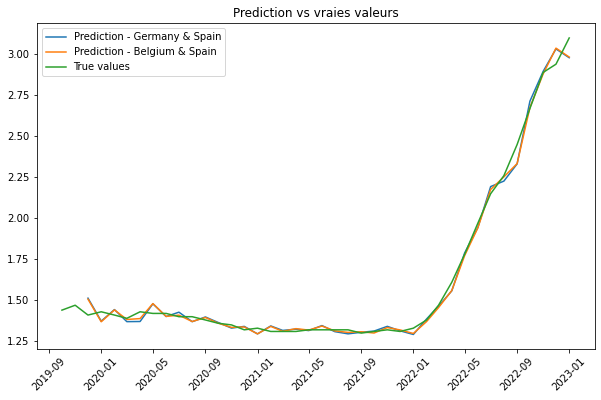

In [53]:
plt.figure(figsize=(10,6))
plt.plot(y_pred_ols.iloc[:,0]+ df.rates[train+2:].shift(1))
plt.plot(y_pred_ols2.iloc[:,0]+ df.rates[train+2:].shift(1))
plt.plot(df.rates[train+1:])
plt.legend(['Prediction - Germany & Spain','Prediction - Belgium & Spain','True values']);
plt.xticks(rotation = 45);
plt.title("Prediction vs vraies valeurs");

Visuelement, on ne peut pas voir des différences importantes entre 2 modèles. Procédons donc au calcul des métriques.

MAE et RMSE sur les prédictions:

In [54]:
print_mae_rmse_pred(df,y_pred_ols2, y_pred_train_ols2, train, y_test)

Mean Absolute Error on train:  0.02541997164529143
Mean Absolute Error on test:  0.027402231306301983
Root Mean Squared Error on train:  0.0
Root Mean Squared Error on test:  0.1698365508559146


On observe une petite amélioration en termes des deux mesures des résultats quand on remplace la variable de la Belgique à la place de l'Allemagne. Cependant, on observe de l'overfitting. 

# Random forest
Pour améliorer la performance de notre modèle on décide de procéder avec un modèles plus complexe, qui prend en compte différentes interactions entre les features, y compris non-linéaires. Le modèle qu'on va utiliser est Random forest. Cette fois, on prend toutes la features à disposition, ainsi que le décalage 1.

In [55]:
X_rf_raw = dataset.iloc[:train, :-1] # without stationarity
y_rf_raw = dataset.iloc[:train, -1]

In [56]:
X_rf_raw['y_lagged_1'] = y_rf_raw.shift(1)
X_rf_raw =X_rf_raw.dropna()
y_rf_raw = y_rf_raw.iloc[1:]
X_rf_raw

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2003-02-01     4.01     4.11      6.93    4.83            3.81     3.95   
2003-03-01     4.03     4.15      6.93    4.83            3.75     4.00   
2003-04-01     4.16     4.29      6.79    4.80            3.92     4.15   
2003-05-01     3.85     3.95      6.78    4.63            3.73     3.82   
2003-06-01     3.76     3.74      6.78    4.63            3.49     3.62   
...             ...      ...       ...     ...             ...      ...   
2019-04-01     0.31     0.47      0.50    1.49            1.82    -0.04   
2019-05-01     0.24     0.41      0.48    1.34            1.86    -0.13   
2019-06-01     0.03     0.15      0.32    0.82            1.58    -0.31   
2019-07-01    -0.10     0.00      0.43    0.66            1.36    -0.39   
2019-08-01    -0.37    -0.28      0.35    0.44            0.99    -0.65   

            Denmark  Spain  Finland  France  ...  Luxembourg  Latvia  Malta  \
2003-02-01     4.21   4.01     4.05    4.01  ...        3.55    4.77   5.51   
2003-03-01     4.26   4.04     4.09    4.10  ...        3.55    4.99   5.40   
2003-04-01     4.41   4.19     4.23    4.22  ...        3.55    4.99   5.25   
2003-05-01     4.09   3.88     3.91    3.89  ...        3.55    4.95   5.14   
2003-06-01     3.85   3.69     3.70    3.69  ...        2.85    4.89   5.11   
...             ...    ...      ...     ...  ...         ...     ...    ...   
2019-04-01     0.08   1.05     0.34    0.37  ...        0.11    0.58   1.00   
2019-05-01     0.04   0.87     0.25    0.30  ...        0.02    0.51   0.95   
2019-06-01    -0.22   0.50     0.05    0.08  ...       -0.16    0.33   0.72   
2019-07-01    -0.31   0.35    -0.09   -0.07  ...       -0.28    0.15   0.52   
2019-08-01    -0.58   0.14    -0.35   -0.34  ...       -0.54   -0.07   0.21   

            Netherlands  Poland  Portugal  Sweden  Slovenia  Slovakia  \
2003-02-01         3.97    5.66      4.04    4.47      6.65      4.92   
2003-03-01         4.01    5.52      4.08    4.57      6.65      5.01   
2003-04-01         4.23    5.41      4.18    4.72      6.65      4.90   
2003-05-01         3.91    5.12      3.91    4.37      6.65      4.72   
2003-06-01         3.72    5.03      3.77    4.20      6.65      4.70   
...                 ...     ...       ...     ...       ...       ...   
2019-04-01         0.20    2.76      1.18    0.23      0.52      0.57   
2019-05-01         0.11    2.72      1.02    0.07      0.38      0.45   
2019-06-01        -0.09    2.35      0.59   -0.09      0.19      0.25   
2019-07-01        -0.21    2.13      0.44   -0.12     -0.01      0.02   
2019-08-01        -0.50    1.93      0.17   -0.36     -0.06     -0.34   

            y_lagged_1  
2003-02-01        4.67  
2003-03-01        4.54  
2003-04-01        4.47  
2003-05-01        4.39  
2003-06-01        4.24  
...                ...  
2019-04-01        1.75  
2019-05-01        1.72  
2019-06-01        1.67  
2019-07-01        1.61  
2019-08-01        1.56  

[199 rows x 24 columns]

In [57]:
X_rf = dataset.iloc[:train,:-1].diff().dropna() # with stationarity
y_rf = dataset.iloc[:train,-1].diff().dropna()

In [58]:
X_rf['y_lagged_1'] = y_rf.shift(1)
X_rf =X_rf.dropna()
y_rf = y_rf.iloc[1:]
X_rf

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2003-03-01     0.02     0.04      0.00    0.00           -0.06     0.05   
2003-04-01     0.13     0.14     -0.14   -0.03            0.17     0.15   
2003-05-01    -0.31    -0.34     -0.01   -0.17           -0.19    -0.33   
2003-06-01    -0.09    -0.21      0.00    0.00           -0.24    -0.20   
2003-07-01     0.30     0.32     -0.83   -0.04            0.57     0.35   
...             ...      ...       ...     ...             ...      ...   
2019-04-01    -0.07    -0.07     -0.17   -0.25            0.00    -0.05   
2019-05-01    -0.07    -0.06     -0.02   -0.15            0.04    -0.09   
2019-06-01    -0.21    -0.26     -0.16   -0.52           -0.28    -0.18   
2019-07-01    -0.13    -0.15      0.11   -0.16           -0.22    -0.08   
2019-08-01    -0.27    -0.28     -0.08   -0.22           -0.37    -0.26   

            Denmark  Spain  Finland  France  ...  Luxembourg  Latvia  Malta  \
2003-03-01     0.05   0.03     0.04    0.09  ...        0.00    0.22  -0.11   
2003-04-01     0.15   0.15     0.14    0.12  ...        0.00    0.00  -0.15   
2003-05-01    -0.32  -0.31    -0.32   -0.33  ...        0.00   -0.04  -0.11   
2003-06-01    -0.24  -0.19    -0.21   -0.20  ...       -0.70   -0.06  -0.03   
2003-07-01     0.32   0.34     0.31    0.32  ...        0.00   -0.11  -0.16   
...             ...    ...      ...     ...  ...         ...     ...    ...   
2019-04-01    -0.08  -0.08    -0.01   -0.07  ...       -0.06   -0.12  -0.03   
2019-05-01    -0.04  -0.18    -0.09   -0.07  ...       -0.09   -0.07  -0.05   
2019-06-01    -0.26  -0.37    -0.20   -0.22  ...       -0.18   -0.18  -0.23   
2019-07-01    -0.09  -0.15    -0.14   -0.15  ...       -0.12   -0.18  -0.20   
2019-08-01    -0.27  -0.21    -0.26   -0.27  ...       -0.26   -0.22  -0.31   

            Netherlands  Poland  Portugal  Sweden  Slovenia  Slovakia  \
2003-03-01         0.04   -0.14      0.04    0.10      0.00      0.09   
2003-04-01         0.22   -0.11      0.10    0.15      0.00     -0.11   
2003-05-01        -0.32   -0.29     -0.27   -0.35      0.00     -0.18   
2003-06-01        -0.19   -0.09     -0.14   -0.17      0.00     -0.02   
2003-07-01         0.32    0.34      0.33    0.31      0.00      0.10   
...                 ...     ...       ...     ...       ...       ...   
2019-04-01         0.05    0.01     -0.14   -0.06     -0.15     -0.11   
2019-05-01        -0.09   -0.04     -0.16   -0.16     -0.14     -0.12   
2019-06-01        -0.20   -0.37     -0.43   -0.16     -0.19     -0.20   
2019-07-01        -0.12   -0.22     -0.15   -0.03     -0.20     -0.23   
2019-08-01        -0.29   -0.20     -0.27   -0.24     -0.05     -0.36   

            y_lagged_1  
2003-03-01       -0.13  
2003-04-01       -0.07  
2003-05-01       -0.08  
2003-06-01       -0.15  
2003-07-01       -0.14  
...                ...  
2019-04-01       -0.03  
2019-05-01       -0.03  
2019-06-01       -0.05  
2019-07-01       -0.06  
2019-08-01       -0.05  

[198 rows x 24 columns]

On applique le modèles sur les données stationarisées et non-stationarisées. On précise qu'on veut un nombre des arbres égale à 5. Cela est dû au fait qu'on a très peu de données et on veut éviter le 'over-fitting'.

In [59]:
rf = RandomForestRegressor(n_estimators = 5, random_state = 42)
rf_raw = RandomForestRegressor(n_estimators = 5, random_state = 42)

rf.fit(X_rf, y_rf)
rf_raw.fit(X_rf_raw, y_rf_raw)

RandomForestRegressor(n_estimators=5, random_state=42)

In [60]:
x_test = dataset.iloc[train:, :-1].diff().dropna()
y_test = dataset.diff().iloc[train:,-1].dropna()
x_test['y_lagged_1'] = y_test.shift(1)
x_test =x_test.dropna()
x_test = x_test.iloc[1:]
x_test.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2019-11-01     0.11     0.12     -0.03    0.07            0.15     0.12   
2019-12-01     0.05     0.05     -0.04   -0.01            0.04     0.05   
2020-01-01    -0.05    -0.04     -0.03    0.04            0.11    -0.01   
2020-02-01    -0.17    -0.10     -0.03   -0.05           -0.15    -0.16   
2020-03-01     0.17     0.11      0.03    0.70           -0.19    -0.07   

            Denmark  Spain  Finland  France  ...  Luxembourg  Latvia  Malta  \
2019-11-01     0.12   0.19     0.13    0.14  ...        0.13    0.10   0.11   
2019-12-01     0.05   0.04     0.04    0.06  ...        0.04    0.06   0.03   
2020-01-01     0.00  -0.01    -0.03   -0.05  ...       -0.02   -0.05  -0.02   
2020-02-01    -0.15  -0.15    -0.16   -0.17  ...       -0.18   -0.15  -0.12   
2020-03-01     0.00   0.25     0.11    0.13  ...        0.07   -0.02   0.14   

            Netherlands  Poland  Portugal  Sweden  Slovenia  Slovakia  \
2019-11-01         0.12    0.09      0.16    0.16      0.08      0.29   
2019-12-01         0.05   -0.02      0.06    0.07      0.03      0.04   
2020-01-01        -0.03    0.20     -0.04    0.04      0.07      0.00   
2020-02-01        -0.17   -0.16     -0.12   -0.16     -0.05     -0.13   
2020-03-01         0.01   -0.27      0.46   -0.12     -0.02      0.04   

            y_lagged_1  
2019-11-01        0.03  
2019-12-01       -0.06  
2020-01-01        0.02  
2020-02-01       -0.02  
2020-03-01       -0.02  

[5 rows x 24 columns]

In [61]:
x_test_raw = dataset.iloc[train:, :-1].diff().dropna()
y_test_raw = dataset.diff().iloc[train:,-1].dropna()
x_test_raw['y_lagged_1'] = y_test_raw.shift(1)
x_test_raw =x_test_raw.dropna()
x_test_raw = x_test_raw.iloc[1:]
x_test_raw.head()

Austria  Belgium  Bulgaria  Cyprus  Czech Republic  Germany  \
2019-11-01     0.11     0.12     -0.03    0.07            0.15     0.12   
2019-12-01     0.05     0.05     -0.04   -0.01            0.04     0.05   
2020-01-01    -0.05    -0.04     -0.03    0.04            0.11    -0.01   
2020-02-01    -0.17    -0.10     -0.03   -0.05           -0.15    -0.16   
2020-03-01     0.17     0.11      0.03    0.70           -0.19    -0.07   

            Denmark  Spain  Finland  France  ...  Luxembourg  Latvia  Malta  \
2019-11-01     0.12   0.19     0.13    0.14  ...        0.13    0.10   0.11   
2019-12-01     0.05   0.04     0.04    0.06  ...        0.04    0.06   0.03   
2020-01-01     0.00  -0.01    -0.03   -0.05  ...       -0.02   -0.05  -0.02   
2020-02-01    -0.15  -0.15    -0.16   -0.17  ...       -0.18   -0.15  -0.12   
2020-03-01     0.00   0.25     0.11    0.13  ...        0.07   -0.02   0.14   

            Netherlands  Poland  Portugal  Sweden  Slovenia  Slovakia  \
2019-11-01         0.12    0.09      0.16    0.16      0.08      0.29   
2019-12-01         0.05   -0.02      0.06    0.07      0.03      0.04   
2020-01-01        -0.03    0.20     -0.04    0.04      0.07      0.00   
2020-02-01        -0.17   -0.16     -0.12   -0.16     -0.05     -0.13   
2020-03-01         0.01   -0.27      0.46   -0.12     -0.02      0.04   

            y_lagged_1  
2019-11-01        0.03  
2019-12-01       -0.06  
2020-01-01        0.02  
2020-02-01       -0.02  
2020-03-01       -0.02  

[5 rows x 24 columns]

In [62]:
# Use the forest's predict method on the test data
predictions_rf = rf.predict(x_test)
predictions_raw_rf = rf_raw.predict(x_test_raw)

# Calculate the absolute errors
errors = abs(predictions_rf - y_test.iloc[2:])
errors_train = abs(rf.predict(X_rf) - y_rf)
errors_raw = abs(predictions_raw_rf - y_test_raw.iloc[2:])
errors_raw_train = abs(rf.predict(X_rf_raw) - y_rf_raw)

# Print out the mean absolute error (mae)
print('Mean Absolute Error on test:', round(np.mean(errors), 2))
print('Mean Absolute Error on train:', round(np.mean(errors_train), 2))
print('Mean Absolute Error on raw data on test:', round(np.mean(errors_raw), 2))
print('Mean Absolute Error on raw data on train:', round(np.mean(errors_raw_train), 2))

print('Root Mean Squared Error on test: '+ str(round(np.sqrt(np.mean(errors**2)),2)))
print('Root Mean Squared Error on train: '+ str(round(np.sqrt(np.mean(errors_train**2)),2)))
print('Root Mean Squared Error on raw data on test: '+ str(round(np.sqrt(np.mean(errors_raw**2)),2)))
print('Root Mean Squared Error on raw data on train: '+ str(round(np.sqrt(np.mean(errors_raw_train**2)),2)))

Mean Absolute Error on test: 0.05
Mean Absolute Error on train: 0.01
Mean Absolute Error on raw data on test: 1.57
Mean Absolute Error on raw data on train: 3.44
Root Mean Squared Error on test: 0.07
Root Mean Squared Error on train: 0.02
Root Mean Squared Error on raw data on test: 1.57
Root Mean Squared Error on raw data on train: 3.63


On observe des valeurs de rmse et de mae plus élevé pour le modèle utilisant des variables non-stationaires. Ceci vient du fait que le range sur lequel est calculé le modèle est différent du modèle stationnaire. Le rmse et MAE ne sont donc pas comparable. Cepednat, on n'observe pas d'overfitting: les erreurs de test sont plus faible que les erreurs de train

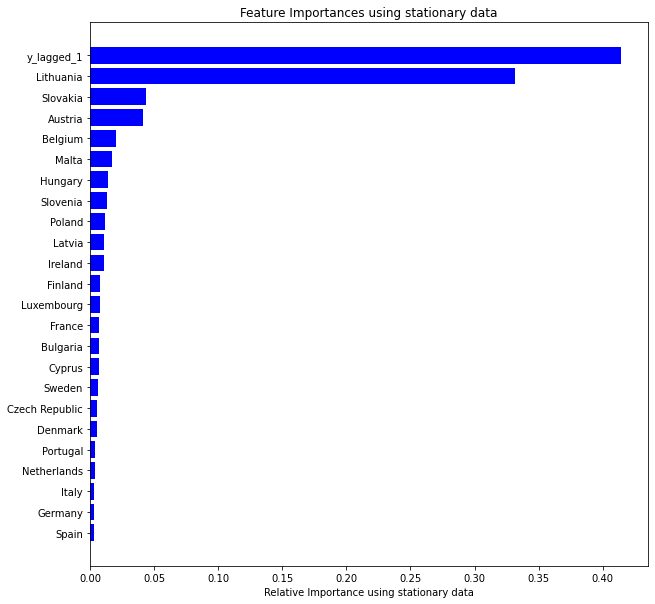

In [63]:
indices = np.argsort(rf.feature_importances_)

plt.figure(figsize=(10,10))
plt.title('Feature Importances using stationary data')
plt.barh(range(len(indices)), rf.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_rf.columns[i] for i in indices])
plt.xlabel('Relative Importance using stationary data')
plt.show()

On observe que les "features" les plus importantes sont décalage 1, Lituanie, Slovaquie, Autriche et Bélgique.

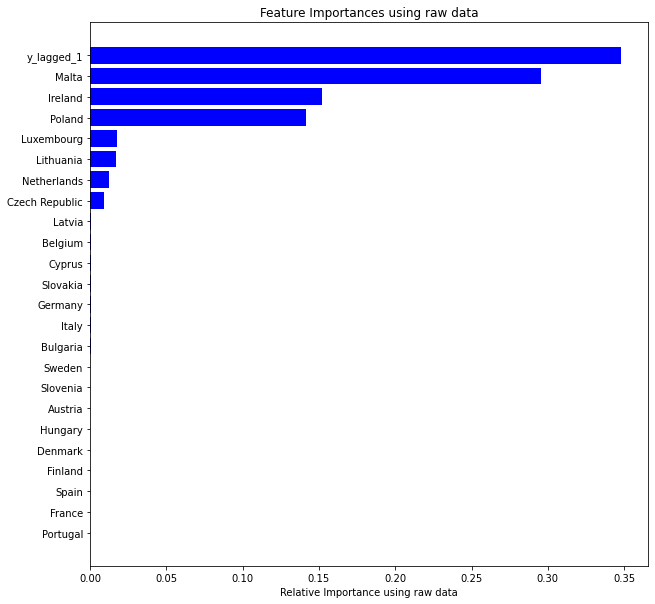

In [64]:
indices = np.argsort(rf_raw.feature_importances_)

plt.figure(figsize=(10,10))
plt.title('Feature Importances using raw data')
plt.barh(range(len(indices)), rf_raw.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_rf_raw.columns[i] for i in indices])
plt.xlabel('Relative Importance using raw data')
plt.show()

Comme dans le graph précedent on oberve que les variables les plus importantes sont décalage 1, Malte, Irelande, Pologne et Luxembourg.

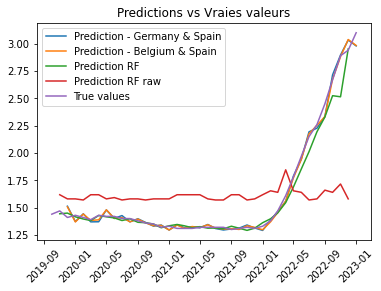

In [65]:
plt.plot(y_pred_ols.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.plot(y_pred_ols2.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.plot(y_test.iloc[2:].index,df.rates[train+1:-1].shift(1).dropna() + predictions_rf) 
plt.plot(y_test_raw.iloc[2:].index,predictions_raw_rf)
plt.plot(df.rates[train+1:])
plt.legend(['Prediction - Germany & Spain','Prediction - Belgium & Spain','Prediction RF','Prediction RF raw','True values']);
plt.xticks(rotation = 45);
plt.title("Predictions vs Vraies valeurs");

On observe finalement des résultats de prédictions avec le random forest plus faible qu'avec les prédictions faites à partir des estimations de OLS. La principale raison est le manque de donnée d'entrainement et le fait que les variables soient très corrélées entre elles, ce qui n'apporte pas beaucoup de diversité dans les splits du random forest.

**Intuition**

Il nous semble évident que le random forest sans rendre les données stationnaires ait des résultats si éloignés de la vraie serie. 
Notre set de train comprend des données entre 2003 et 2019 et notre set de test des données entre 2019 et 2023. 

Le régime de taux haut dans lequel nous nous trouvons actuellement n'est pas du tout le même que celui connait post-2008, les arbres de décisions sont donc dans l'incapacité de prédire des résultats précis. 

Seulement 5 arbres ont été construit afin de ne pas sur-apprentir (peu de donnée de train). Cependant, l'overfitting est quand même présente avec des erreurs sur les set de train plus faible que les set de test.

# Lasso
Ensuite on décide également d'utiliser une méthode régularisation, appélée LASSO. Cette méthode permet de 'shrinker' certaines fetures à 0 et donc n'utiliser que des variables importantes. On utilise également la validation croisée afin de séléctionner la valeur du paramètre de régularisation.

In [66]:
X = X_rf
y = y_rf
X_test_ = x_test

In [67]:
reg = LassoCV(cv=5, random_state=0).fit(X, y)
pred_lasso = reg.predict(X_test_)
pred_lasso_train = reg.predict(X)

In [68]:
print('The R2 of the model on train set is:',round(reg.score(X, y)*100,2))
print('The R2 of the model on test set is:',round(reg.score(X_test_, pred_lasso)*100,2))

The R2 of the model on train set is: 82.49
The R2 of the model on test set is: 100.0


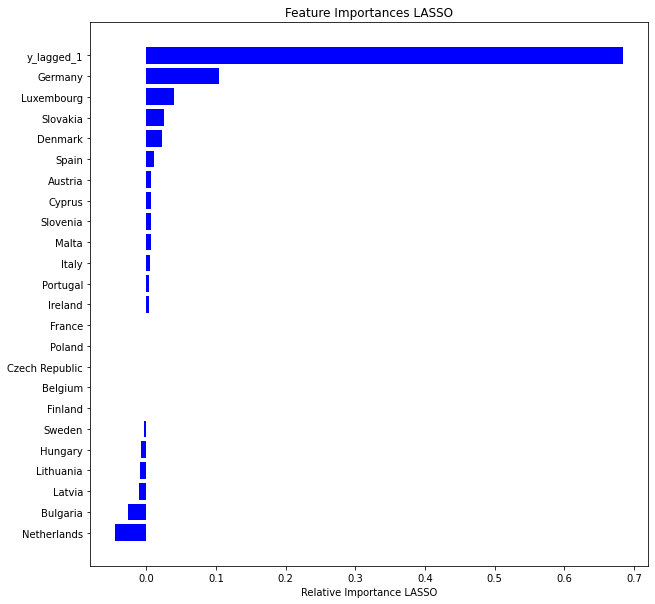

In [69]:
indices = np.argsort(reg.coef_)

plt.figure(figsize=(10,10))
plt.title('Feature Importances LASSO')
plt.barh(range(len(indices)), reg.coef_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance LASSO')
plt.show()

Parmis les variables avec les coéficcients les plus hauts on retrouve de nouveau le décalage 1. On retrouve également L'Allamgne, les Pays-Bas, le Luxembourg et la Boulgarie.

In [70]:
err = np.mean(abs(pred_lasso - y_test[2:]))
print('Mean Absolute Error on test:', err)
err = np.mean(abs(pred_lasso_train - y))
print('Mean Absolute Error on train:', err)
error = np.sqrt(np.sum((pred_lasso - y_test[2:]))**2)
print('Root Mean Squared Error on test:', error)
error = np.sqrt(np.sum((pred_lasso_train - y))**2)
print('Root Mean Squared Error on train:', error)

Mean Absolute Error on test: 0.032425578608280124
Mean Absolute Error on train: 0.022502965000284533
Root Mean Squared Error on test: 0.2655874454690906
Root Mean Squared Error on train: 6.800116025829084e-16


On observe un de l'overfitting: les erreurs du train sont largement inférieur à celle du test. 

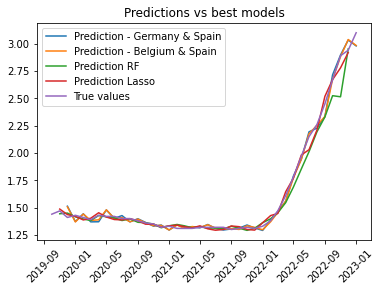

In [71]:
plt.plot(y_pred_ols.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.plot(y_pred_ols2.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.plot(y_test.iloc[2:].index,df.rates[train+1:-1].shift(1).dropna() + predictions_rf) 
plt.plot(X_test_.dropna().index,df.rates[train+1:-1].shift(1).dropna() + pred_lasso)
plt.plot(df.rates[train+1:])
plt.legend(['Prediction - Germany & Spain','Prediction - Belgium & Spain','Prediction RF','Prediction Lasso','True values']);
plt.xticks(rotation = 45);
plt.title("Predictions vs best models");

La raison qui nous a poussé à utiliser LASSO vient des variables qui avaient été sélectionnés dans le Random Forest comme variable importantes. Lasso permet de sélectionner les variables importantes et de régulariser certaine variables (mettre les coefficients à 0).
Ils ont en faite été sélectionnés, car ils agissaient comme des remplacements de la y_lagged_1 lorsque celle-ci n'était pas choisi lors du processus de construction d'arbre du RF.

Les performances sont satisfaisantes surtout que les prédictions, ont était faites sur une période comprenant un changement de régime. Il s'avère que les différents modèles, à l'exception le Random Forest fait sans stationnarité, ont plutôt bien réagi.

# Simulation

Nous allons faire une simulation en utilisant les données des taux de rendements des obligations souveraines allemands et espagnols. L'estimation des paramètres a déjà été réalisée avec OLS. Notre méthode est d'actualiser au fur et à mesure, avec notre prédiction, la variable y_pred_lagged_1. Alors que cette dernière était récupérée historiquement dans la prévision, cette fois-ci, chaque prévision sera utilisée dans l'itération suivante pour simuler les mortgages rates suivants.

In [72]:
# create the test set
X_test = donnee.iloc[train-1:,1:].diff().dropna()
y_test = donnee.iloc[train-1:,0].diff().dropna()
X_test['y_pred_lagged_1'] = np.zeros(len(X_test))
X_test['y_pred_lagged_1'][0] = y_test[0]
X_test.head(5)

Germany  Spain  y_pred_lagged_1
2019-10-01     0.06   0.04            -0.04
2019-11-01     0.12   0.02             0.00
2019-12-01     0.12   0.19             0.00
2020-01-01     0.05   0.04             0.00
2020-02-01    -0.01  -0.01             0.00

In [73]:
params = np.array(model.params).reshape(len(X_test.columns),1) # beta calculé précédement

In [74]:
for i in range(1, len(y_pred_ols)):
    X_test['y_pred_lagged_1'][i] = X_test.iloc[i-1,:] @ params # update y_pred_lagged_1

In [75]:
X_test.head()

Germany  Spain  y_pred_lagged_1
2019-10-01     0.06   0.04        -0.040000
2019-11-01     0.12   0.02        -0.020827
2019-12-01     0.12   0.19         0.001353
2020-01-01     0.05   0.04         0.021580
2020-02-01    -0.01  -0.01         0.023885

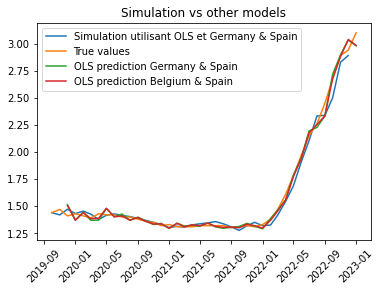

In [76]:
plt.plot(X_test['y_pred_lagged_1'] + df.rates[train:-1].shift(1))
plt.plot(df.rates[201:])
plt.plot(y_pred_ols.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.plot(y_pred_ols2.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.legend(['Simulation utilisant OLS et Germany & Spain','True values', 'OLS prediction Germany & Spain', 'OLS prediction Belgium & Spain']);
plt.xticks(rotation = 45);
plt.title("Simulation vs other models");

In [77]:
print('MAE:', np.mean(abs(X_test['y_pred_lagged_1']+df.rates[train:-1].shift(1) - df.rates[train+1:])))

MAE: 0.03552384483585238


On observe que la simulation est moins précise que la prédiction. Cela s'explique parce que la simulation utilise les yt prédits précédemment au lieu de d'utiliser les données historiques comme la prédiction. 

Référence pour la simulation : https://www.mathworks.com/help/ident/ug/definition-simulation-and-prediction.html

## Gradient boosting

In [78]:
X = X_rf
y = y_rf
X_test_ = x_test

Ici, nous faisons un gradient boosting et un grid search afin d'optimiser les hypermarametres. 

In [79]:
# define the parameters on which ti apply the gird search
params = {
    'n_estimators': [3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5]
}


gbm = GradientBoostingRegressor(random_state=42)


grid_search = GridSearchCV(gbm, param_grid=params, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X, y)

# Get the best hyperparameters from the GridSearchCV object
best_params = grid_search.best_params_

# Instantiate the Gradient Boosting Regressor with the best hyperparameters
gbm = GradientBoostingRegressor(**best_params, random_state=42)

# Fit the model to the training data
gbm.fit(X, y)
print('The R2 of the model on train set is:',round(gbm.score(X, y)*100,2))
print('The R2 of the model on test set is:',round(gbm.score(X_test_.dropna(), y_test[2:])*100,2))

The R2 of the model on train set is: 88.8
The R2 of the model on test set is: 35.38


In [80]:


# Predict the target variable on the test set
y_pred_gbm = gbm.predict(X_test_.dropna())

# Calculate the absolute errors
errors = abs(y_pred_gbm - y_test[2:])
errors_train = abs(gbm.predict(X)- y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error on test:', round(np.mean(errors), 2))
print('Mean Absolute Error on train:', round(np.mean(errors_train), 2))
print('Root Mean Squared Error on test: '+ str(round(np.sqrt(np.mean(errors**2)),2)))
print('Root Mean Squared Error on train: '+ str(round(np.sqrt(np.mean(errors_train**2)),2)))



Mean Absolute Error on test: 0.05
Mean Absolute Error on train: 0.02
Root Mean Squared Error on test: 0.06
Root Mean Squared Error on train: 0.02


On observe de l'overfitting: les erreurs sur le train set sont plus faible que sur le test set. 

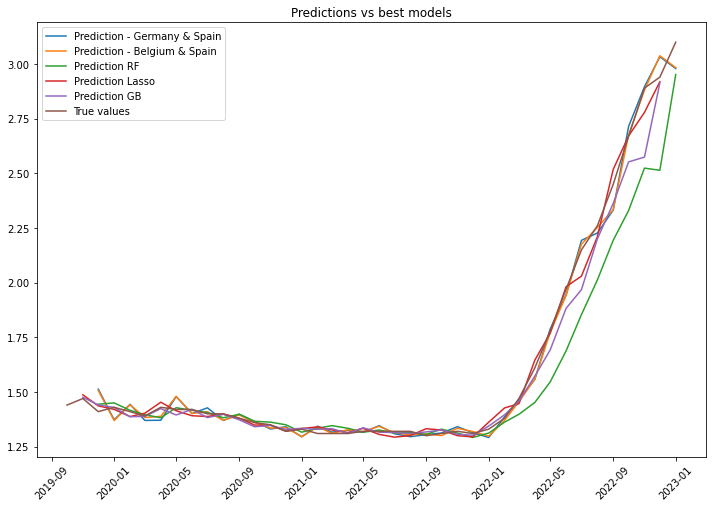

In [81]:
plt.figure(figsize=(12,8))
plt.plot(y_pred_ols.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.plot(y_pred_ols2.iloc[:,0]+ df.rates[train+1:].shift(1))
plt.plot(y_test.iloc[2:].index,df.rates[train+1:-1].shift(1).dropna() + predictions_rf) 
plt.plot(X_test_.dropna().index,df.rates[train+1:-1].shift(1).dropna() + pred_lasso)
plt.plot(X_test_.dropna().index,df.rates[train+1:-1].shift(1).dropna() + y_pred_gbm)
plt.plot(df.rates[train+1:])
plt.legend(['Prediction - Germany & Spain','Prediction - Belgium & Spain','Prediction RF','Prediction Lasso','Prediction GB','True values']);
plt.xticks(rotation = 45);
plt.title("Predictions vs best models");

On observe que finalement le Forest et le Gradient boosting ont les résultats les plus faible.

## KMeans

On a performé un kmeans dans l'optique de extraire des subsets. A partir de ces subsets de données, on peut créer 3 sous modèles. Durant la période de test, on definira grâce au kmeans, la classe de l'observation et utilisera le modèle adapté pour cette classe précise.

In [82]:
pipeline = Pipeline([
 ('scaler', StandardScaler()),
('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_rf, y_rf)
# Predict on the test data
X_rf['y_pred'] = pipeline.predict(X_rf)

In [83]:
pipeline.named_steps['kmeans'].inertia_

3037.519869722383

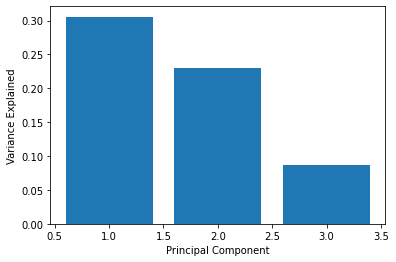

In [84]:
pca = PCA(n_components=3)
pca_result = pd.DataFrame(pca.fit_transform(X_rf.iloc[:, :-1]), columns=['PCA_1', 'PCA_2', 'PCA_3'])
pca_result['y_pred'] = X_rf['y_pred'].values
plt.bar(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [85]:
clusters = []
for label in set(X_rf['y_pred'].values):
    cluster_data = pca_result[pca_result['y_pred'] == label]
    cluster = go.Scatter3d(
        x=cluster_data['PCA_1'],
        y=cluster_data['PCA_2'],
        z=cluster_data['PCA_3'],
        mode='markers',
        name=f'Cluster {label}',
        marker=dict(
            size=5,
            color=['red', 'blue', 'green'][label],
            opacity=0.8
        )
    )
    clusters.append(cluster)

layout = go.Layout(
    title='KMeans Clustering in 3D',
    scene=dict(
        xaxis=dict(title='PCA_1'),
        yaxis=dict(title='PCA_2'),
        zaxis=dict(title='PCA_3')
    )
)

fig = go.Figure(data=clusters, layout=layout)
fig.show()

Selection de modèle pour chaque classe

In [128]:
# Define the models to be tested
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [5, 50, 100, 200],
            'model__max_depth': [2, 5, 10],
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(),
        'params': {
            'model__n_estimators': [5, 50, 100, 200],
            'model__max_depth': [2, 5, 10],
        }
    },
    {
        'name': 'Lasso',
        'model': Lasso(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10, 100]
        }
    }
]

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', None)
])

'model__learning_rate': [0.05, 0.1, 0.15]

SyntaxError: illegal target for annotation (<ipython-input-128-4332920217c6>, line 34)

In [129]:
# Perform the grid search for each model
for label in set(X_rf['y_pred'].values):
    globals()['best_score'+str(label)] = -1
    print('Cluster'+str(label))
    cluster_data = X_rf[X_rf['y_pred'] == label]
    idx = cluster_data.index
    for model in models:
        print(f'Testing {model["name"]}...')
        pipe.set_params(model=model['model'])
        globals()['grid' + str(label)] = GridSearchCV(pipe, param_grid=model['params'], cv=5)
        globals()['grid' + str(label)].fit(cluster_data.iloc[:, :-1], y.loc[idx])
        best_score = globals()["grid" + str(label)].best_score_
        best_params= globals()["grid" + str(label)].best_params_
        if (globals()['best_score'+str(label)]==-1) | (best_score > globals()['best_score'+str(label)]):
            globals()['model'+str(label)] = globals()['grid' + str(label)]
            globals()['best_score'+str(label)] = best_score
            globals()['best_params'+str(label)] = best_params              
        

Cluster0
Testing RandomForestRegressor...


ValueError: Invalid parameter learning_rate for estimator RandomForestRegressor(). Check the list of available parameters with `estimator.get_params().keys()`.

In [125]:
print('best model label 0:',model0)
print('---------------------------------------------------------------')
print('best model label 1:',model1)
print('---------------------------------------------------------------')
print('best model label 2:',model2)

best model label 0: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__max_depth': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200]})
---------------------------------------------------------------
best model label 1: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]})
---------------------------------------------------------------
best model label 2: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__max_depth': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200]})
